In [1]:
# Design a 12 ns NOT gate (π rotation) on the computational subspace {|0>, |1>} 
# of a transmon qubit.
# The control pulse is optimized to:
#   - Suppress leakage into the non-computational level |2>,
#   - Minimize the total pulse energy, given by the integral ∫ (Ωx² + Ωy²) dt.
# The system is modeled with an anharmonicity of -100 MHz.
# Estimated script runtime: ~5 seconds.

# AUTHOR:
#     Leo Van Damme / Technical University of Munich, 2025

In [2]:
from Module.parameters import ProblemParameters
from Module.grape import *
import matplotlib.pyplot as plt
from Module.pulse_utils import *
from Module.phys_utils import StateProbability, EigState, GateFidelityMap

In [3]:
# Problem parameters
p = ProblemParameters(
            alpha = -100e6,     # Anharmonicity in Hz
            nuRef = 10e6,       # Reference pulse amplitude
            NLevels = 3,        # Number of energy levels
            dt = 0.1e-9,        # Timestep in s.
            Nt = 120,           # Number of time steps
            CompSpace = [0,1],  # Computational states indices
            Target = [[0,1],    # Target gate
                      [1,0]]    
            )

In [4]:
# Initial guess: Drag-like pulse
ux0, uy0 = InitPulse(p,PulseType = "CosDrag", ThetaTar=np.pi, NCoeffs=3)

Initializing pulse...
Compiling cost function... Done.
Pulse initialized.


In [5]:
# Optimization options
gopt=Grape(
        Maxiter=500,        # Maximum number of iterations
        EnergyMinimum=True  # Find minimum-energy solution
        )

In [6]:
# Optimize the pulse
ux, uy, J = gopt.Optimize(p,ux0, uy0)

Compiling cost function... Done.
Preoptimization = 10/10, Cost (+ penalty) = 0.000000
########### OPTIMIZATION RESULTS ###########
Cost before optimization: 0.019948400777
Cost after optimization: 0.000000000000
Number of Iterations: 1
Number of iteration during preoptimization: 140


In [7]:
# Compare fidelity
FDrag = GateFidelityMap(p,ux0,uy0)
FGrape = GateFidelityMap(p,ux,uy)
print(f"Fidelity of DRAG pulse = {FDrag.item()*100:.3f} %")
print(f"Fidelity of GRAPE pulse = {FGrape.item()*100:.3f} %")


Computation of the gate fidelity map 1/1
Computation of the gate fidelity map 1/1
Fidelity of DRAG pulse = 98.005 %
Fidelity of GRAPE pulse = 100.000 %


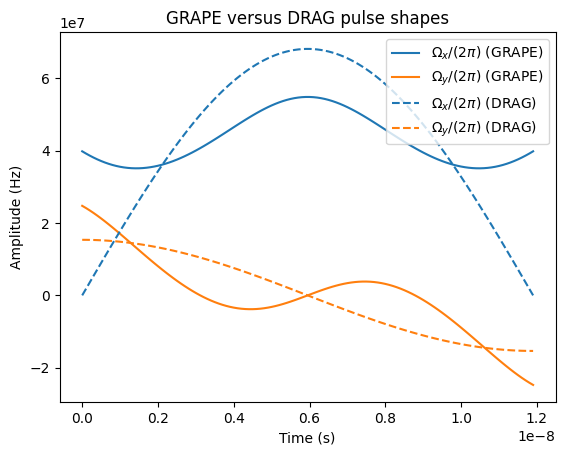

In [8]:
# Display In-phase and quadrature component in Hz
plt.figure()
plt.plot(p.tc,p.nuRef*ux,p.tc,p.nuRef*uy)

# Display Drag-like initial pulse
plt.plot(p.tc,p.nuRef*ux0,linestyle='--', color='#1f77b4')
plt.plot(p.tc,p.nuRef*uy0,linestyle='--', color='#ff7f0e')

# Labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Hz)')
plt.legend([r'$\Omega_x/(2\pi)$ (GRAPE)', r'$\Omega_y/(2\pi)$ (GRAPE)',
            r'$\Omega_x/(2\pi)$ (DRAG)', r'$\Omega_y/(2\pi)$ (DRAG)'],
            loc='upper right')
plt.title(f"GRAPE versus DRAG pulse shapes")

plt.show()


In [9]:
# Compute leakage as a function of time

# Probability of the transition |0> → |2>
psi_init = EigState(StateIndice='|0>', NLevels=p.NLevels)
psi_meas = EigState(StateIndice='|2>', NLevels=p.NLevels)
P02 = StateProbability(p,ux,uy,InitState=psi_init, MeasState=psi_meas)

# Probability of the transition |1> → |2>
psi_init = EigState(StateIndice='|1>', NLevels=p.NLevels)
psi_meas = EigState(StateIndice='|2>', NLevels=p.NLevels)
P12 = StateProbability(p,ux,uy,InitState=psi_init, MeasState=psi_meas)

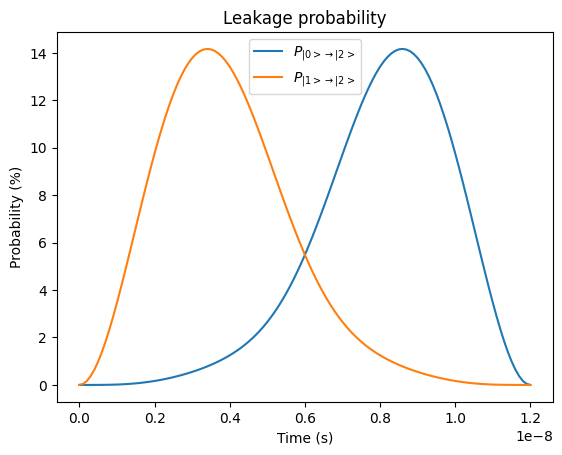

In [10]:
# Display leakage
plt.figure()
plt.plot(p.t,P02*100)
plt.plot(p.t,P12*100)
plt.xlabel('Time (s)')
plt.ylabel('Probability (%)')
plt.legend([r'$P_{|0>\rightarrow |2>}$', r'$P_{|1>\rightarrow |2>}$'])
plt.title("Leakage probability")
plt.show()
